# IL2233 Lab 1 - Time series analysis

## Task 1 Exploratory Data Analysis

Task 1.1 White noise series

In [105]:
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import numpy as np
from random import gauss, seed, randint
from pandas import Series, plotting, read_excel, DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, acovf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from numpy.fft import fft, rfft
from scipy.io import loadmat
from math import sqrt

### 1.1.1

In [82]:
# Line plot, histogram, density plot, box plot, lag-1 plot, ACF and PACF graphs
def plot_all(series: Series, lags: int):
    fig.subplots_adjust()
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

    series.plot(ax=axes[0,0], kind='line', title='Lineplot', xlabel='SV #', ylabel='Value')
    series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
    series.plot(ax=axes[1,1], kind='density', title='Density', xlabel='', ylabel='density')
    series.plot(ax=axes[1,0], kind='box')
    plotting.lag_plot(series, ax=axes[2,0])
    autocorrelation_plot(series, ax=axes[2,1])
    plot_pacf(series, lags=lags, ax=axes[3,0]);

def ljungbox(series: Series):
    return sm.stats.acorr_ljungbox(series)

def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')

MEAN: -0.07120429237582035
STDDEV: 0.9922827480232803


/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


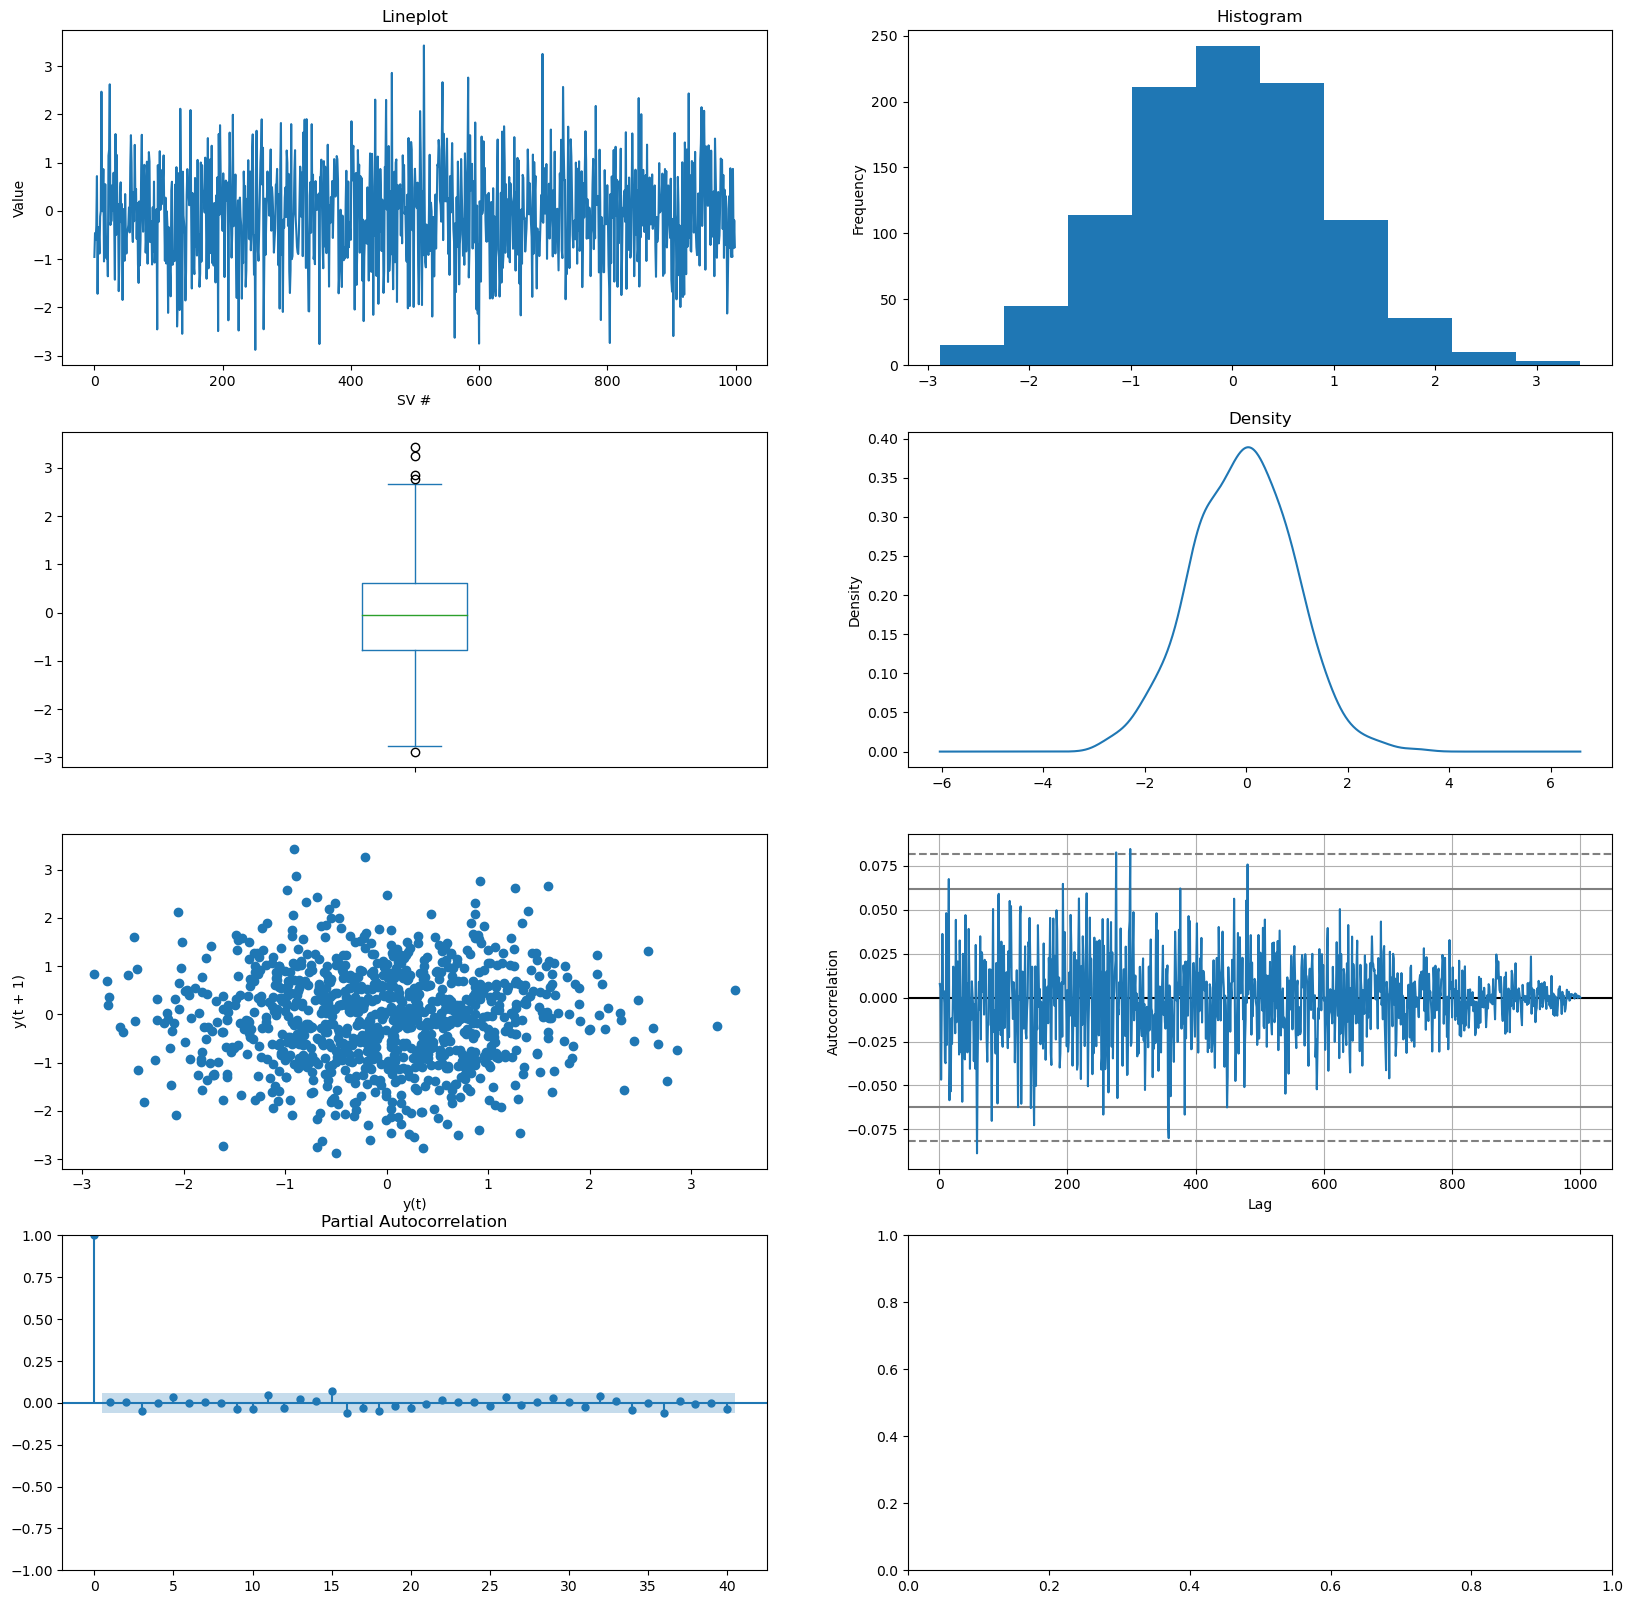

In [4]:
# seed the random number generator
seed(10)
# create white noise series
series = Series([gauss(0.0, 1.0) for _ in range(1000)])
# Mean and standard deviation
print("MEAN:", series.mean())
print("STDDEV:", series.std())
plot_all(series, lags=40)

### 1.1.2

MEAN: 0.0033041176413629446
STDDEV: 0.09791546516302142


/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


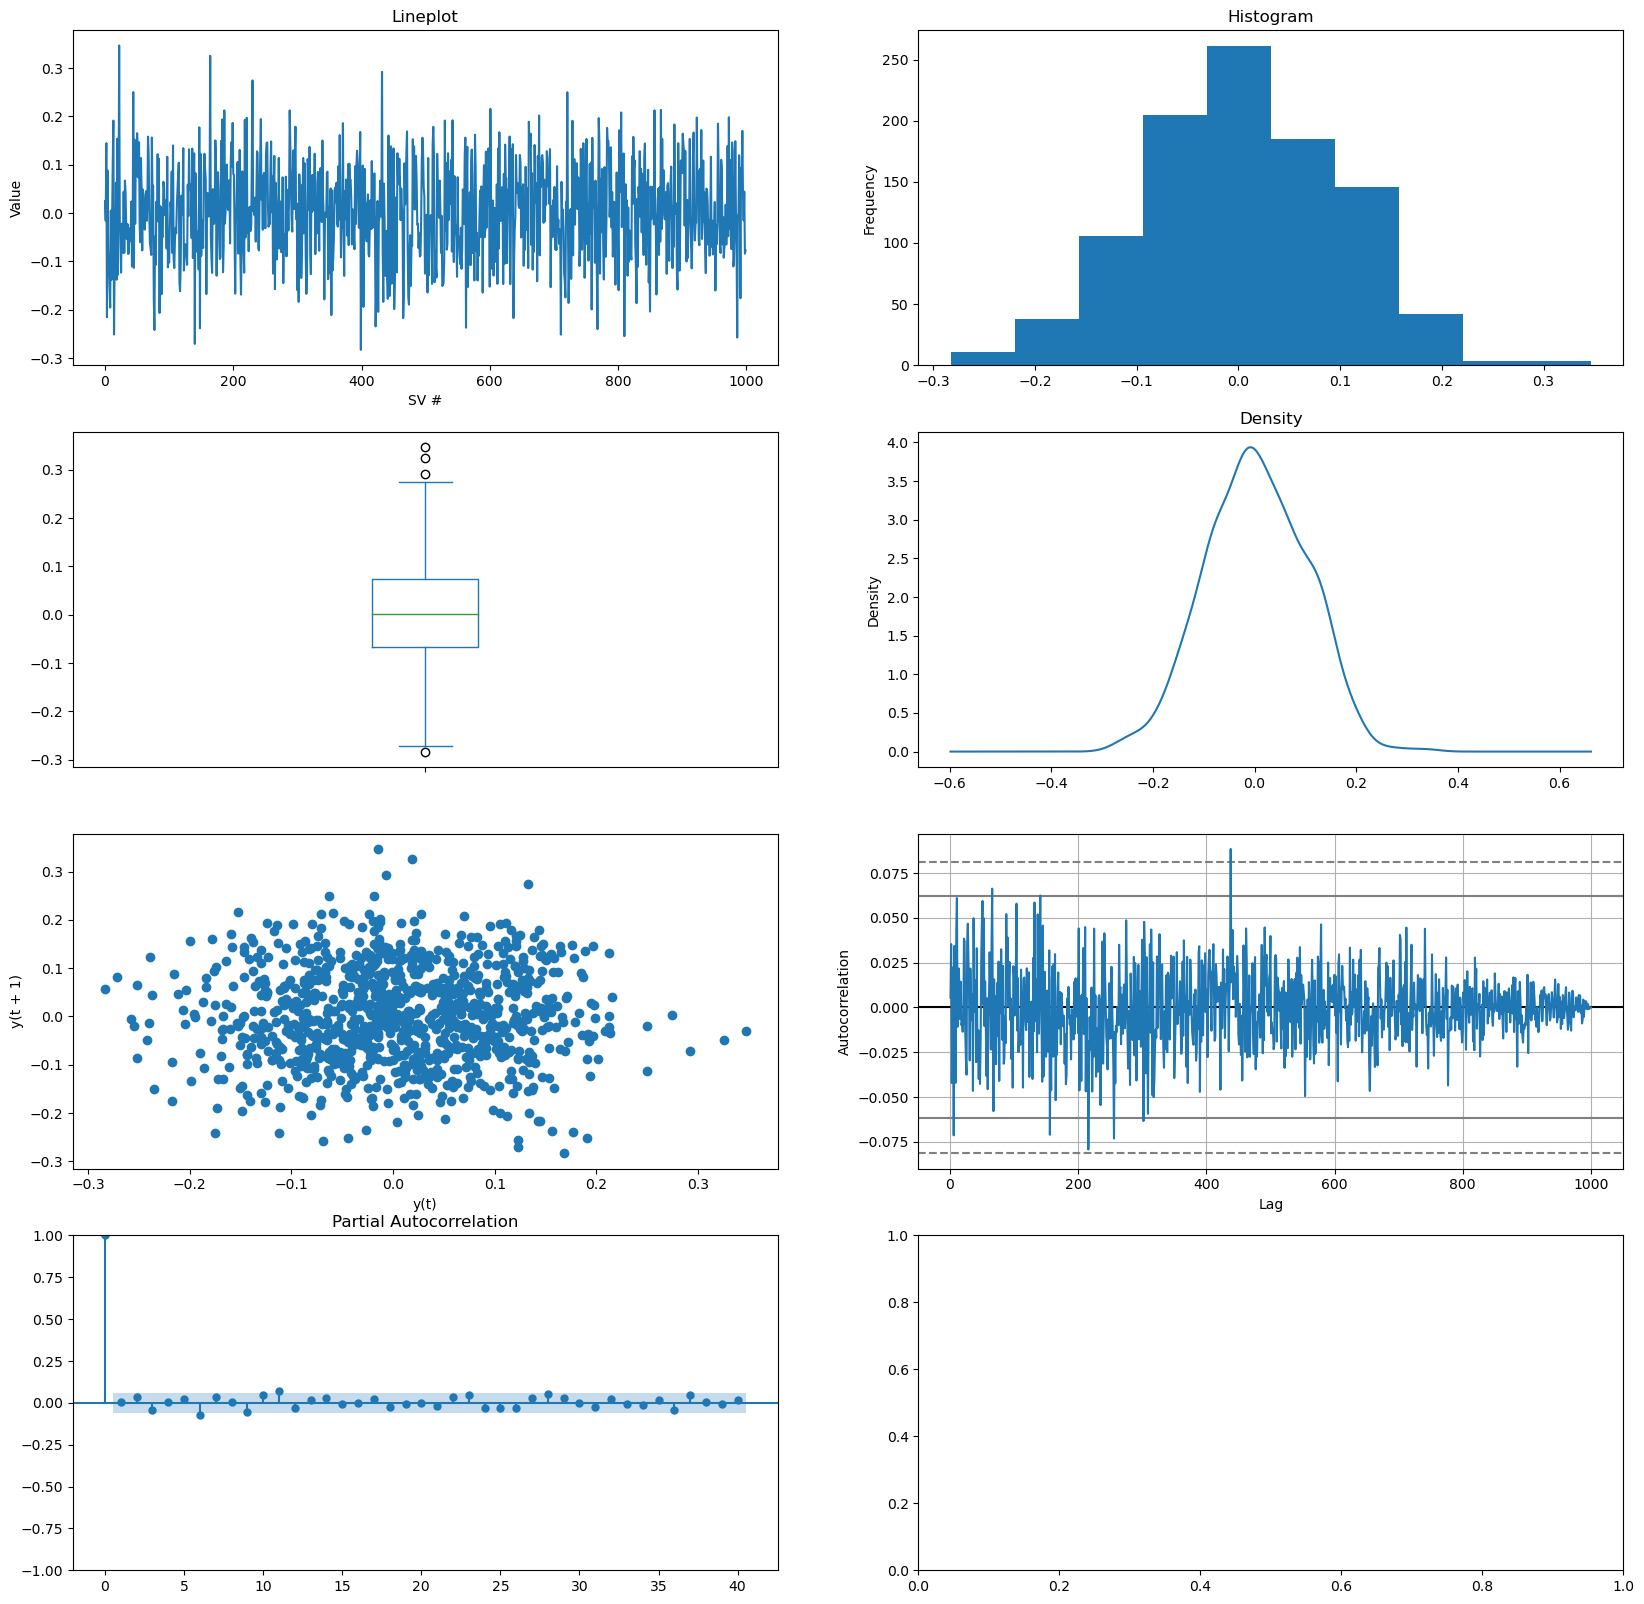

In [5]:
series_100 = [[gauss(0.0, 1.0) for _ in range(1000)] for _ in range(100)]
series_100_avg = []
for i in range(1000):
    sum = 0
    for j in range(100):
        sum += series_100[j][i]
    series_100_avg.append(sum / 100)
series_100_avg = Series(series_100_avg)

# Mean and standard deviation
print("MEAN:", series_100_avg.mean())
print("STDDEV:", series_100_avg.std())
plot_all(series_100_avg, 40)

### 1.1.3

The results below show that the calculated probabilities for the varying lag are set above the threshold of 0.05. It can be observed that the data is randomly distributed.

In [6]:
ljungbox(series_100_avg)

,lb_stat,lb_pvalue
1,0.029767,0.863020
2,1.287263,0.525381
3,3.072530,0.380577
4,3.111408,0.539358
5,3.616514,0.605836
6,8.757487,0.187683
7,9.945298,0.191695
8,9.948899,0.268631
9,11.740194,0.228355
10,13.597836,0.192138


### 1.1.4
For the results below, we find that the ADF statistic is lower than the critical values and that the p-value remains lower than significant value and thus we consider that the data is stationary

In [7]:
adfuller_test(series_100_avg)

ADF Statistic: -9.025475788812402
p-value: 5.6255555472623464e-15
Critial Values:
1%, -3.436979275944879
Critial Values:
5%, -2.8644668170148058
Critial Values:
10%, -2.5683283824496153


## Task 1.2 Random Walk Series

### Task 3.1.2.1 and Task 3.1.2.2 - Realize random walk series and plot the series

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


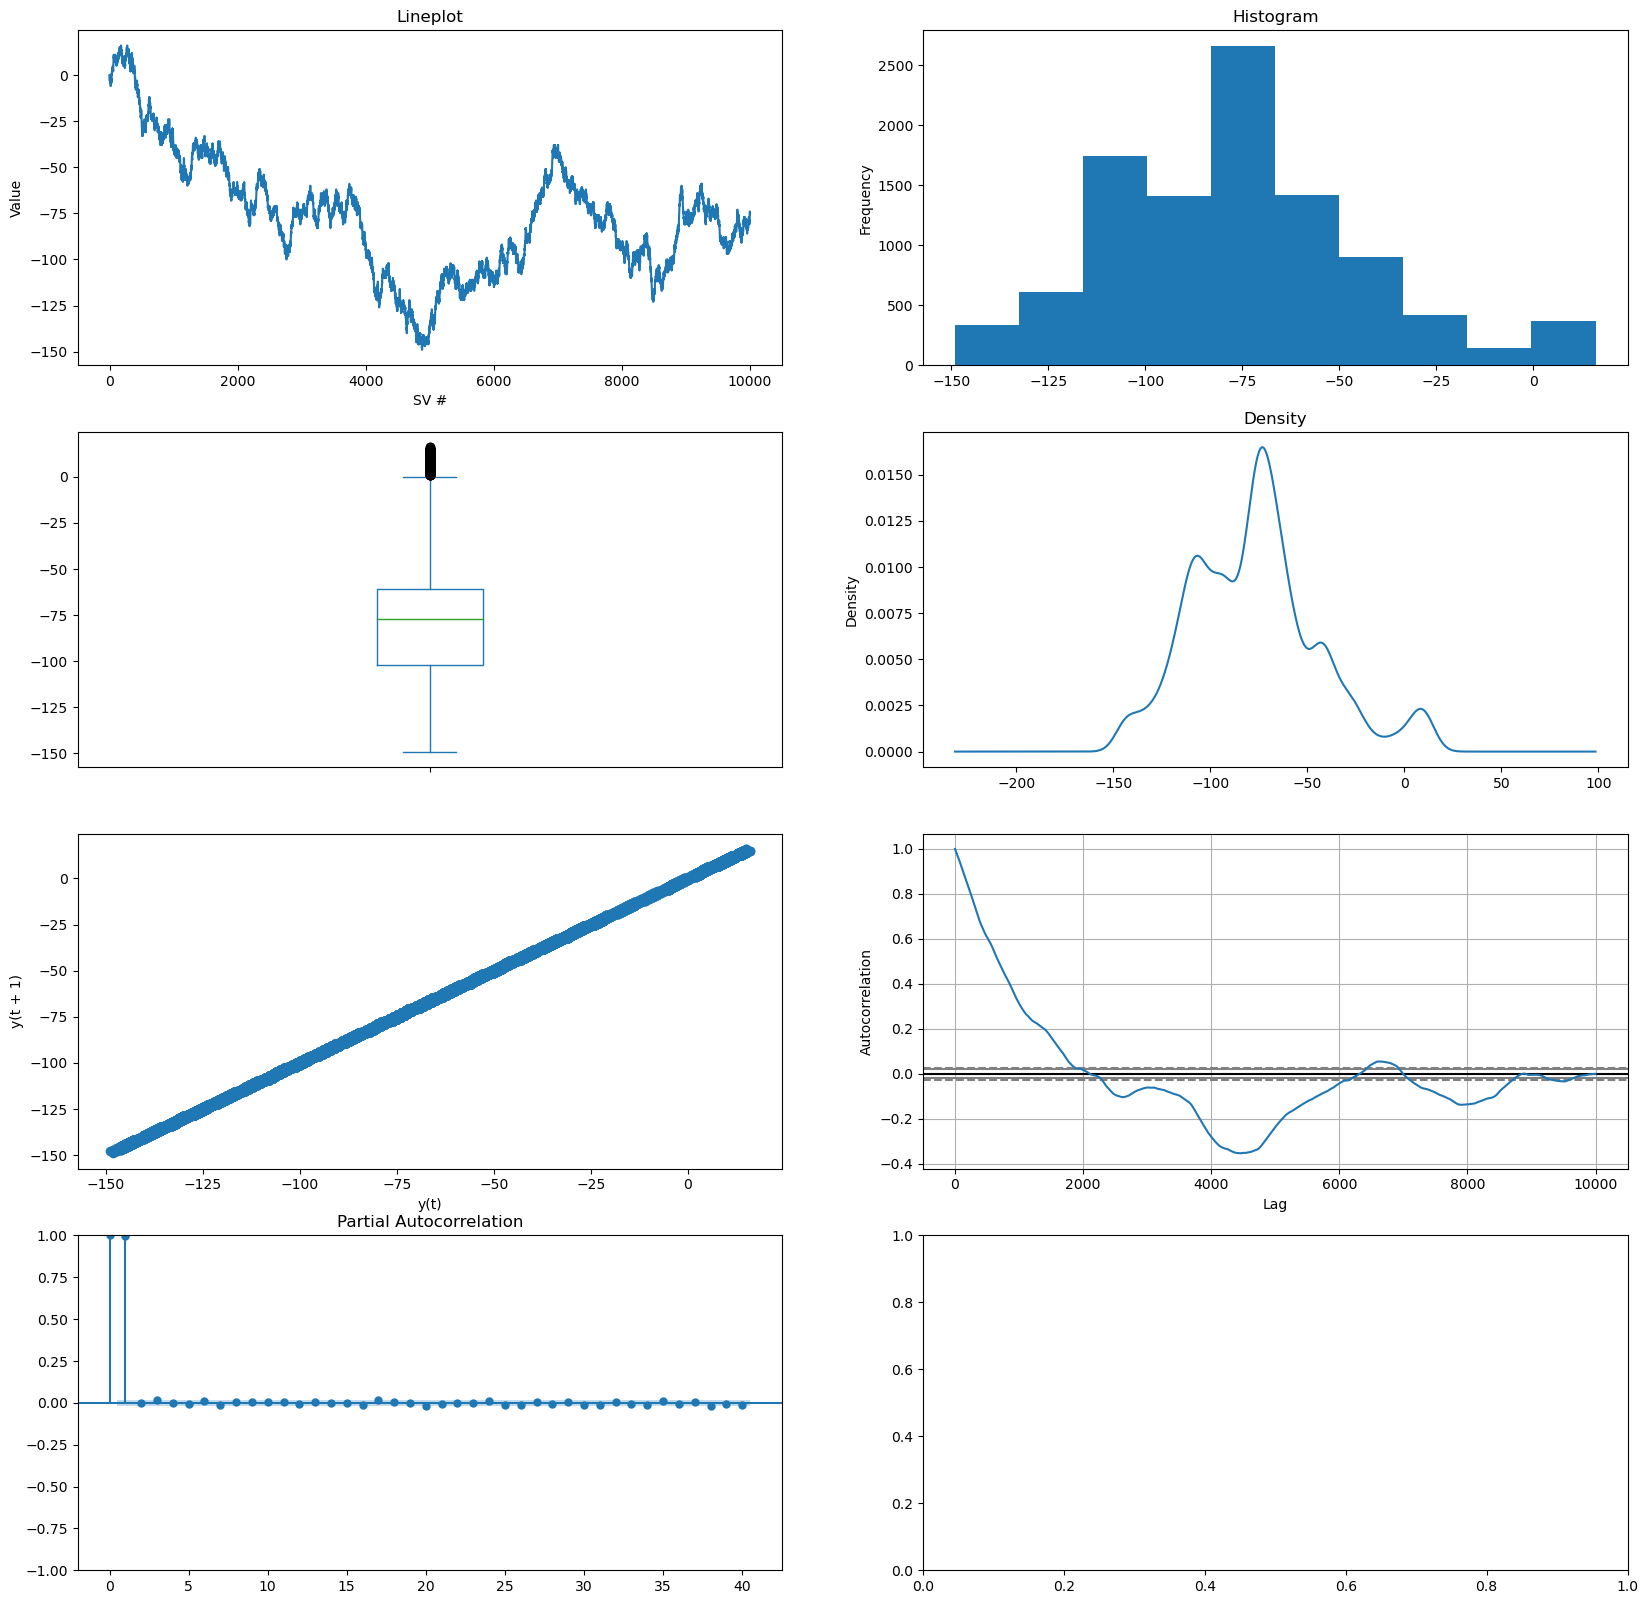

In [8]:
def random_walk(N: int) -> Series:
    series = [0]
    for _ in range(N-1):
        random_val = randint(0,1)
        if random_val == 0:
            random_val = -1
        series.append(series[-1] + random_val)
    
    return Series(series)

seed(time.time())

random_walk_series = random_walk(10000)
plot_all(random_walk_series, lags=40)

### Task 3.1.2.4 - Ljung Box Test

We see from the Ljungbox test that the series is dependent. This makes sense since the random walk series IS dependent and NOT random

In [9]:
sm.stats.acorr_ljungbox(random_walk_series)

,lb_stat,lb_pvalue
1,9988.068077,0.0
2,19962.233584,0.0
3,29922.960988,0.0
4,39870.327178,0.0
5,49804.212878,0.0
6,59724.859164,0.0
7,69631.986423,0.0
8,79525.787471,0.0
9,89406.452508,0.0
10,99274.114109,0.0


### Task 3.2.1.4 - Stationarity Test with ADF

 The ADF shows that the series is NOT stationary through the test statistics and the p-value. One possibility to make it stationary is to create a new series `z_t = y_t - y_t-1`, which would give constant mean and constant variaton which leads to stationary distribution.

In [10]:
adfuller_test(random_walk_series)

ADF Statistic: -2.4393609502998745
p-value: 0.13093376856098832
Critial Values:
1%, -3.4310041633725734
Critial Values:
5%, -2.861829101294412
Critial Values:
10%, -2.566923883481157


### 3.1.2 - Additional Questions
- What methods can be used to check if a series is random? Describe both visualiza- tion and statistic test methods.

- What methods can be used to check if a series is stationary? Describe both visual- ization and statistic test methods.

- Why is white noise important for time-series prediction?

- What is the difference between a white noise series and a random walk series?

- Is it possible to change a random walk series into a series without correlation across its values ? If so, how? Explain also why it can.


## Task 3.1.3 - Global land temperature anomalies series

### Task 3.1.3.1 and Task 3.1.3.2 - Read data and Plotting etc.

In [11]:
temp_anomalies: DataFrame = read_excel('global_land_temp_anomalies.xlsx', sheet_name=1, names=[None, "Year", "Anomaly"], usecols="B:C", skiprows=4)

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


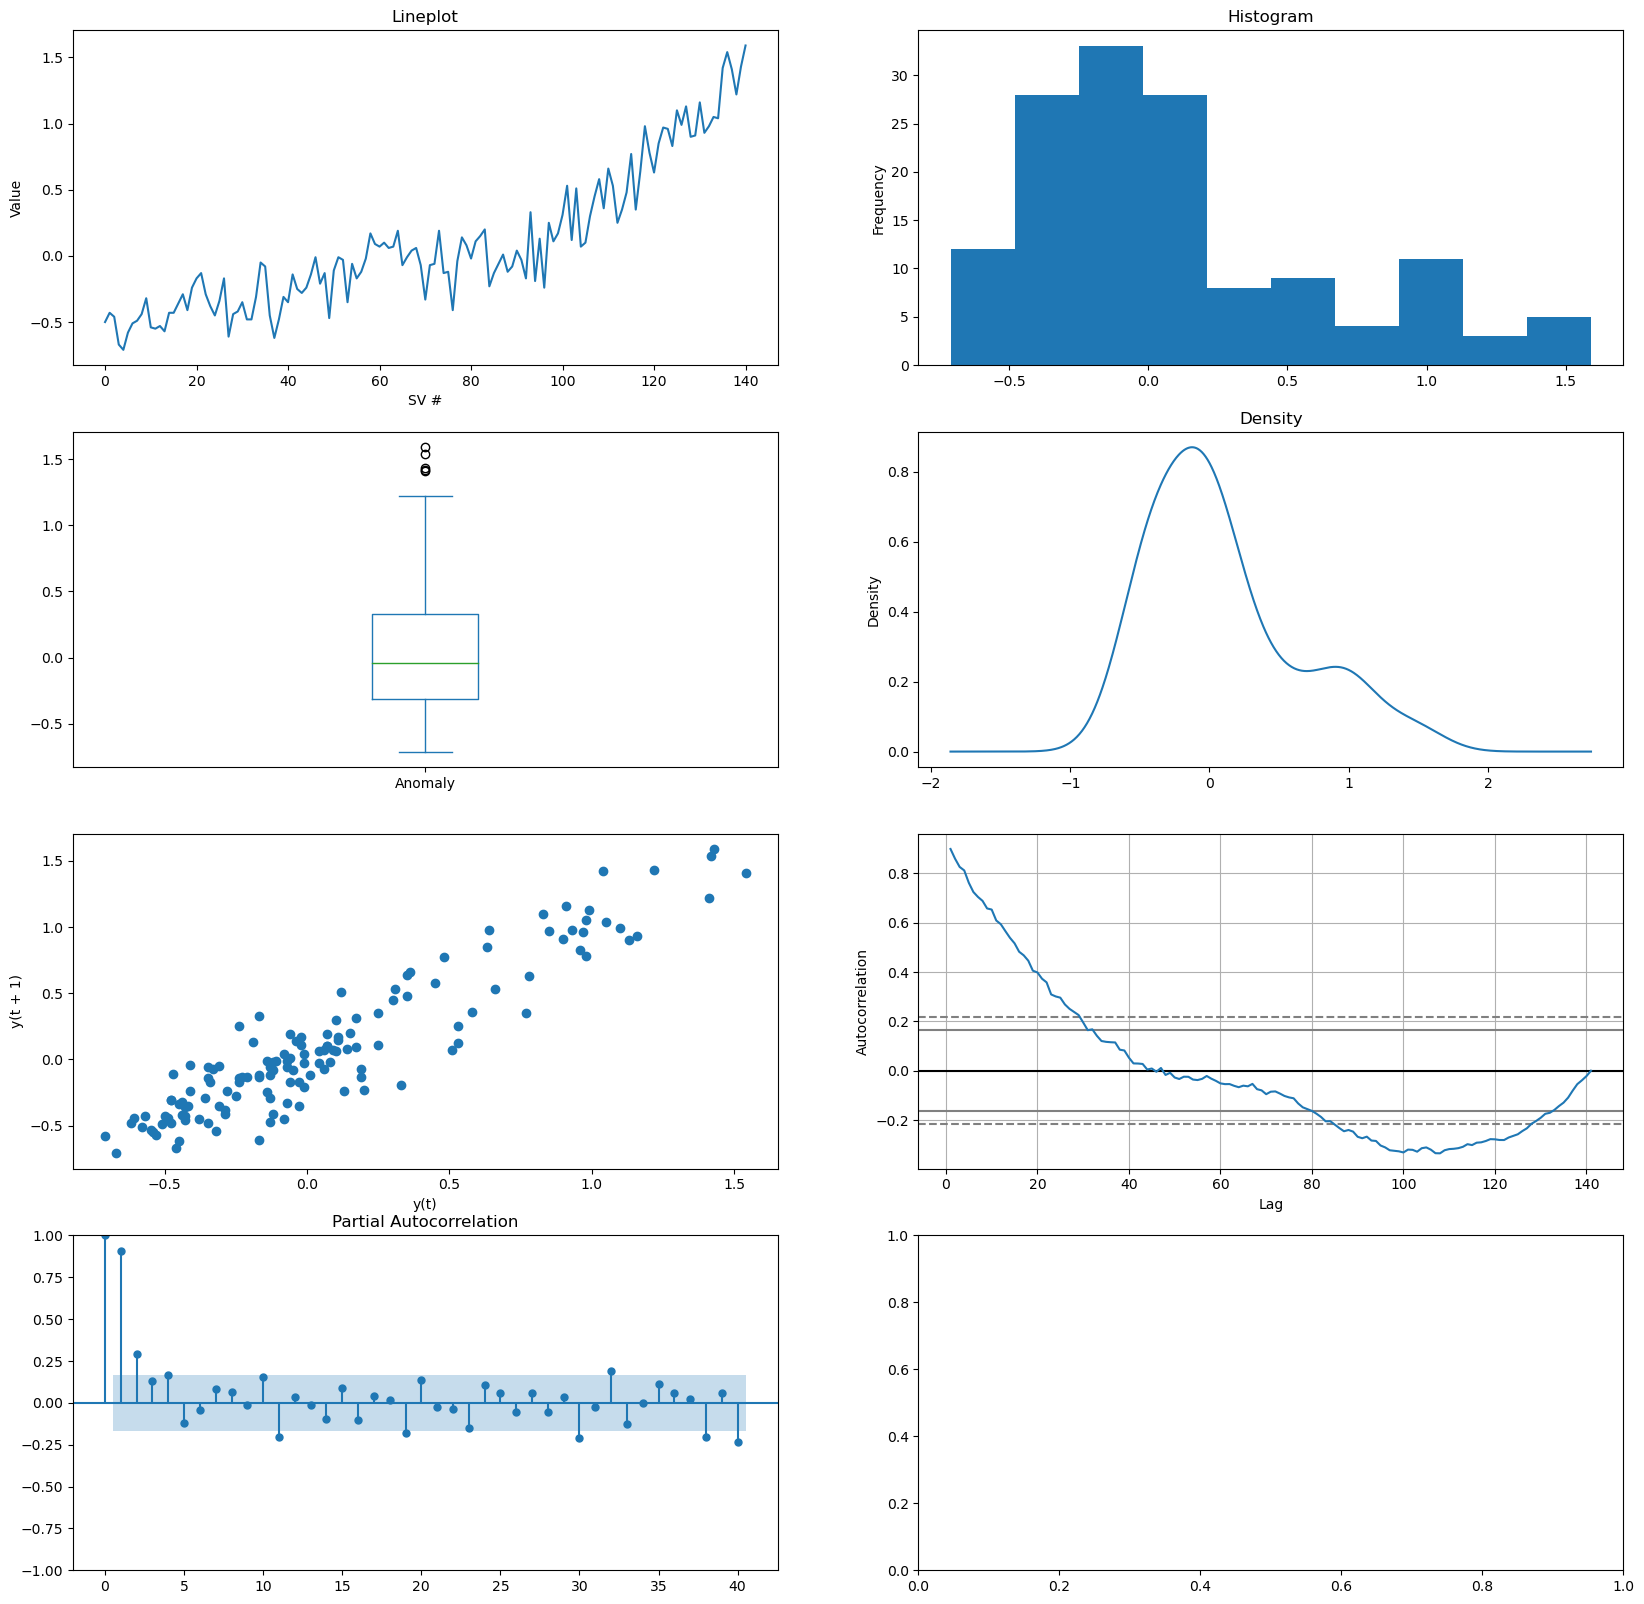

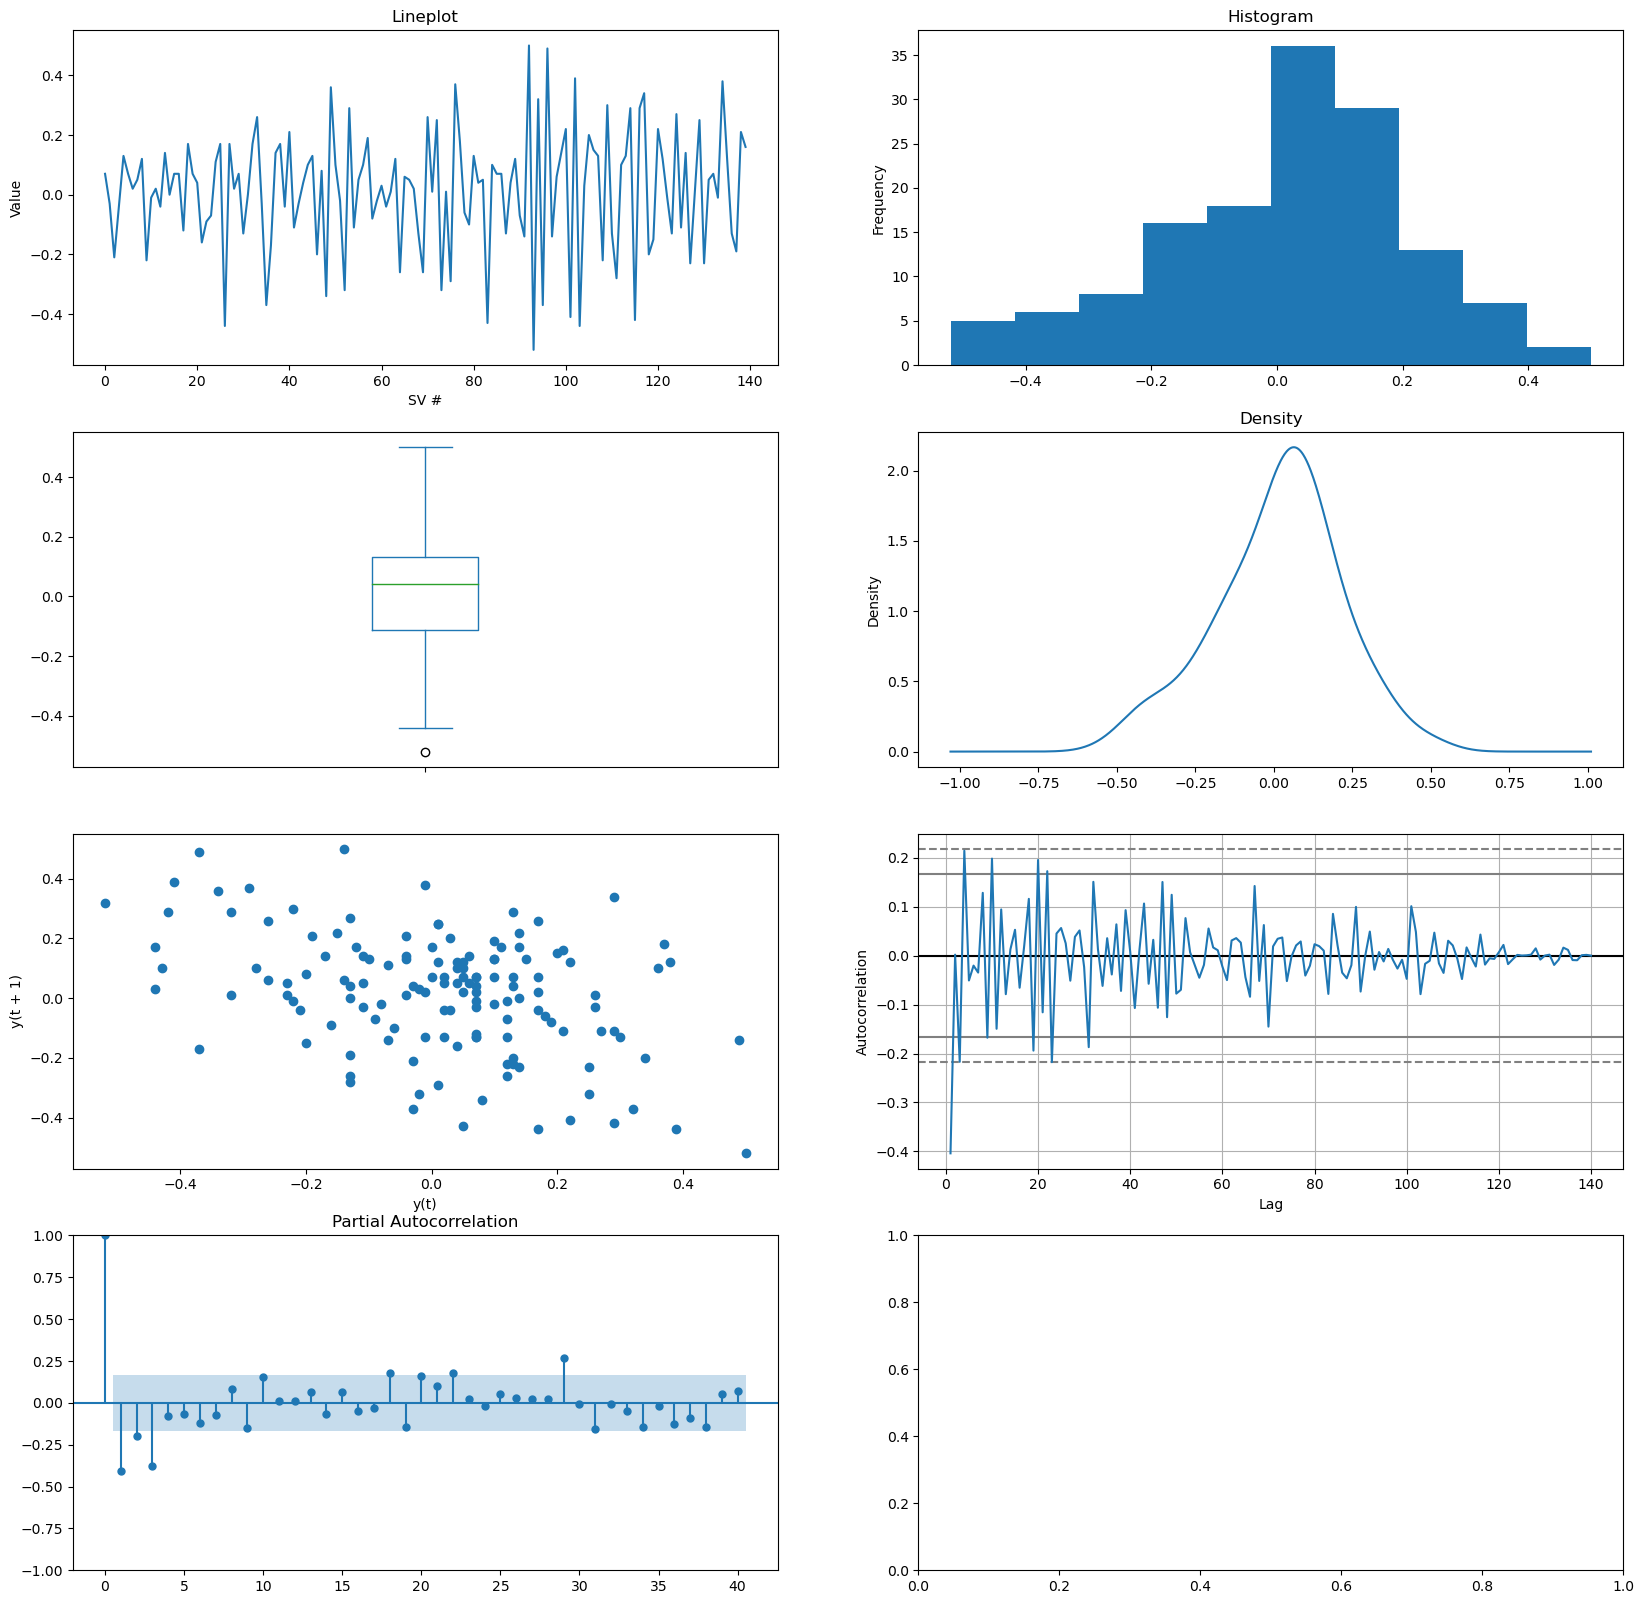

In [12]:
anomalies_series = Series(temp_anomalies['Anomaly'].squeeze())
fod_series = Series([anomalies_series[i] - anomalies_series[i-1] for i in range(1, len(anomalies_series))])
plot_all(anomalies_series, lags=40)
plot_all(fod_series, lags=40)

### Task 3.1.3.3 - Test if the first order difference series is random or not

In [13]:
ljungbox(anomalies_series)

,lb_stat,lb_pvalue
1,116.259661,4.169678e-27
2,223.253408,3.320002e-49
3,322.867467,1.116892e-69
4,419.782964,1.476885e-89
5,505.753172,4.575034e-107
6,584.065601,6.376375e-123
7,658.670577,5.588820e-138
8,730.484090,1.952353e-152
9,796.520600,1.192652e-165
10,862.145059,8.904478e-179


In [14]:
ljungbox(fod_series)

,lb_stat,lb_pvalue
1,23.320097,1.371594e-06
2,23.320603,8.629695e-06
3,30.150398,1.283094e-06
4,36.849474,1.934610e-07
5,37.229219,5.388000e-07
6,37.291533,1.544821e-06
7,37.471550,3.817995e-06
8,39.943228,3.282680e-06
9,44.211360,1.290320e-06
10,50.208598,2.443360e-07


### Task 3.1.3.4 - ADF Test to check if original and differenced series are stationary or not

In [15]:
adfuller_test(anomalies_series)

ADF Statistic: 0.938292641937885
p-value: 0.993570249862259
Critial Values:
1%, -3.479007355368944
Critial Values:
5%, -2.8828782366015093
Critial Values:
10%, -2.5781488587564603


It can be observed that the original temperature anomaly serires is not stationary because all critical values are below the ADF statistic.

In [16]:
adfuller_test(fod_series)

ADF Statistic: -12.165503286659847
p-value: 1.460486937213061e-22
Critial Values:
1%, -3.479007355368944
Critial Values:
5%, -2.8828782366015093
Critial Values:
10%, -2.5781488587564603


It can be observed that the **first order difference** of the anomalies series makes the distribution stationary, since all critical values are above the ADF statistic.

### Task 3.1.3.5 - Classical decomposition and STL decomposition on the first order difference series
Discussion question: Which period to use?

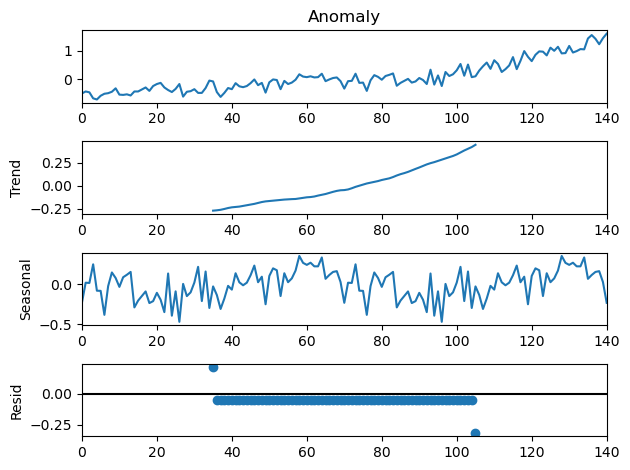

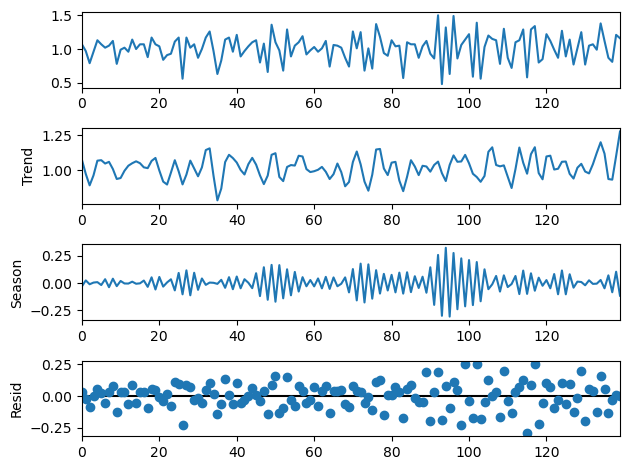

In [17]:
result = seasonal_decompose(fod_series.map(lambda x: x+1), model="additive", period=2) # Not sure of period
result = seasonal_decompose(anomalies_series, model="additive", period=70) # Not sure of period
# result = seasonal_decompose(fod_series.map(lambda x: x+1), model="additive", period=70) # here's a trend
result.plot();
stl_result = STL(fod_series.map(lambda x: x+1), period=2)
stl_result.fit().plot();

### Task 3.1.3 - Questions
- What is a stationary time series?

- If a series is not stationary, is it possible to transform it into a stationary one? If so, give one technique to do it?

- Is the global land temperature anomaly series stationary? Why or why not?

- Is the data set after the first-order difference stationary?

- Why is it useful to decompose a time series into a few components? What are the typical components in a time-series decomposition?


## Task 3.2.2 - Feature Extraction

### Task 3.2.2.1 - Frequency components of a synthetic time-series signal
Data: Generate a series of five sequential sine wave signals for five seconds, each sine
wave lasting 1 second. The nth sine wave signal xn = sin(2π · n · f ), where f = 10, and
n = 1, 2, 3, 4, 5, i.e., frequency 10Hz, 20Hz, 30Hz, 40Hz and 50Hz. The series is digitalized
with a sampling rate is 200 Hz.



### Line plot

<Axes: >

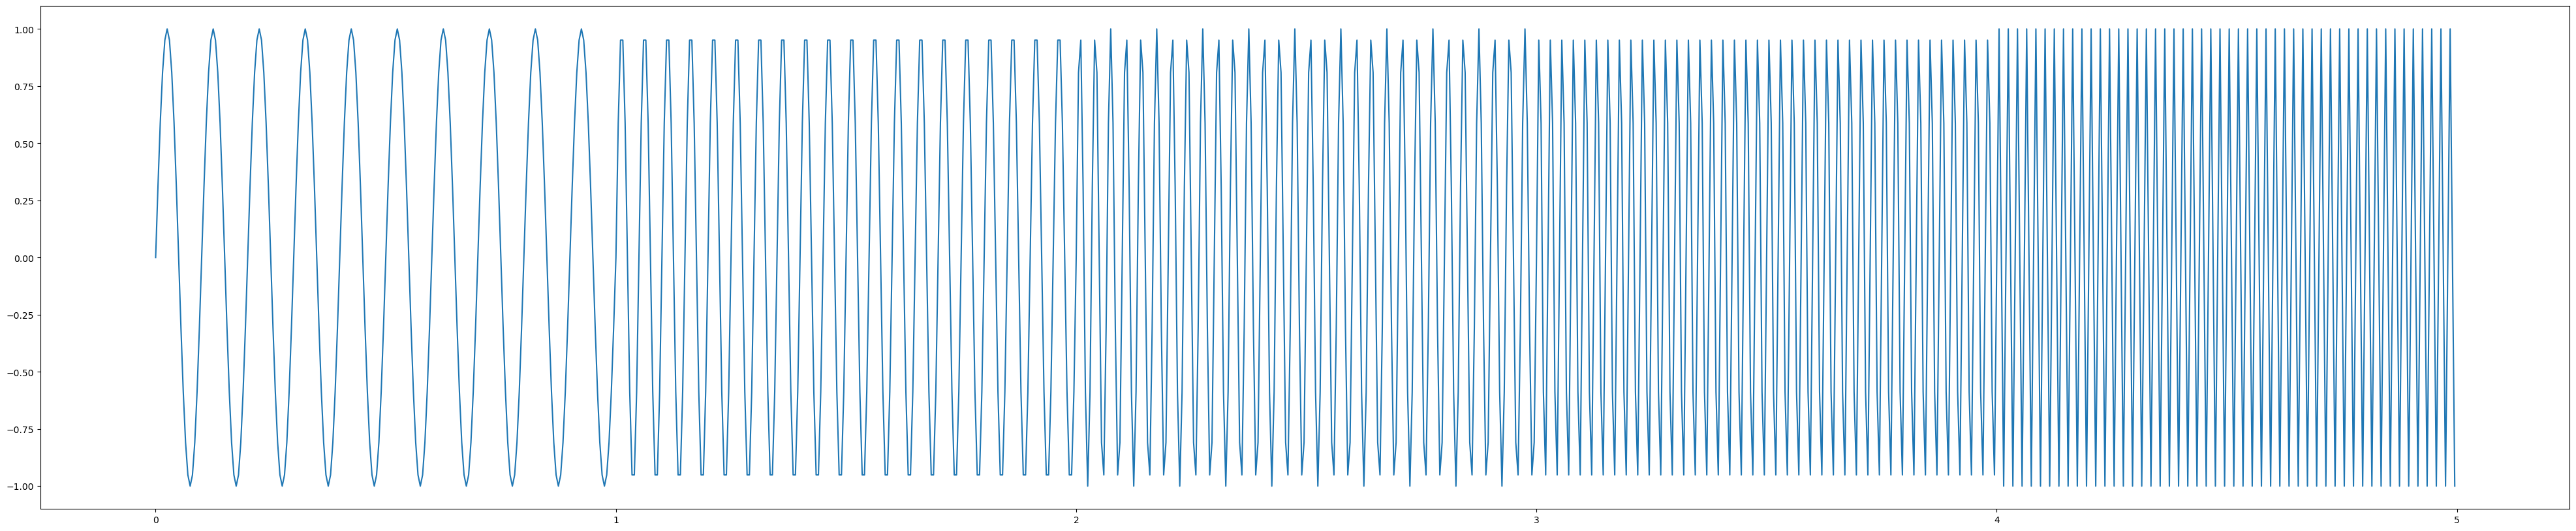

In [18]:
# Generate sine waves
def gen_sine(freq_200_0_to_1) -> Series:
    sine_y = []
    for i in range(5):
        sine_y.extend(freq_200_0_to_1.map(
            lambda t: np.sin(2*np.pi*(i+1)*10*t)
        ))
    return Series(sine_y)
    # return Series([freq_200_0_to_1.map(",
    #         lambda t: np.sin(2*np.pi*(i+1)*10*t))]",
    #     for i in range(5))",


# Line plot 
x_wave = []
timestamps = Series(np.linspace(0, 0.995, 200))
y_values = gen_sine(timestamps)
y_values.index = np.linspace(0, 4.995, 1000)
y_values.plot(figsize = (50, 10), kind='line')

### Power spectrum/Power density graph

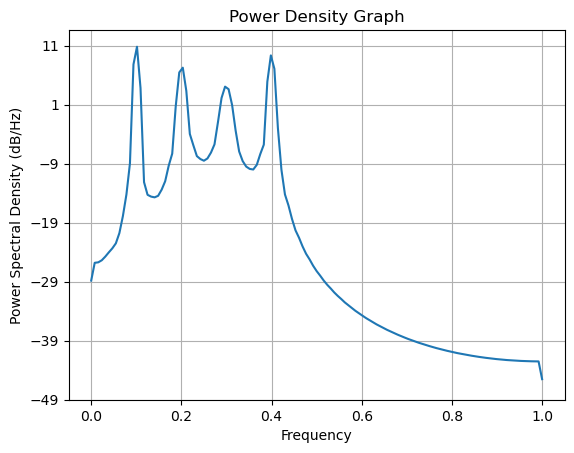

In [19]:
# Power density graph
plt.psd(y_values);
plt.title("Power Density Graph");

### Spectogram of the series

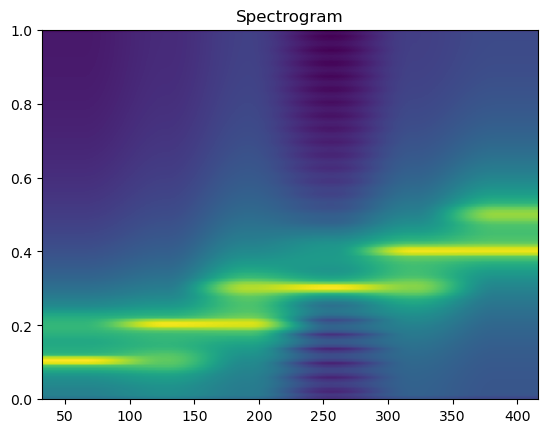

In [20]:
# Spectrogram
plt.specgram(y_values);
plt.title("Spectrogram");

### Draw and compare the ACF and PACF graphs of the first one-second (frequency 10Hz) and the second one-second series (frequency 20Hz), with lags up to 50.

By inspecting the plots we can see that neither of the two intervals are stationary time series. This is due to the ACF which is outside the 5% and 10% boundaries. We also know by theory that periodic time series are not stationary. Regarding PACF there is a strange pattern for the 10Hz time series that is not repeated for the other frequencies. The results are expected since the sine wave is repeating according to its frequency and we see strong correlation between the data points.

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


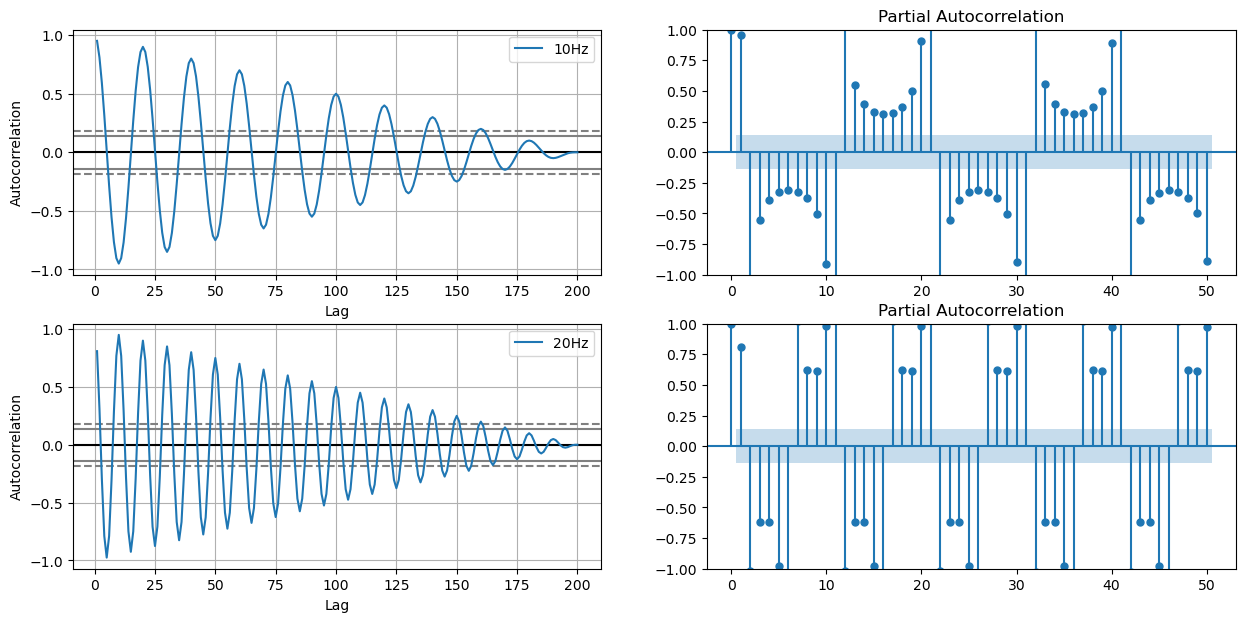

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
fig.subplots_adjust()
autocorrelation_plot(y_values.iloc[0:200], label='10Hz', ax=axes[0,0]);
plot_pacf(y_values.iloc[0:200], lags=50, label='10Hz', ax=axes[0,1]);
autocorrelation_plot(y_values.iloc[200:400], label='20Hz', ax=axes[1,0]);
plot_pacf(y_values.iloc[200:400], lags=50, label='20Hz', ax=axes[1,1]);

## Task 2.2 Statistical features and discovery of event-related potential

### Task 2.2.1 Visuallize the event related potential (ERP)

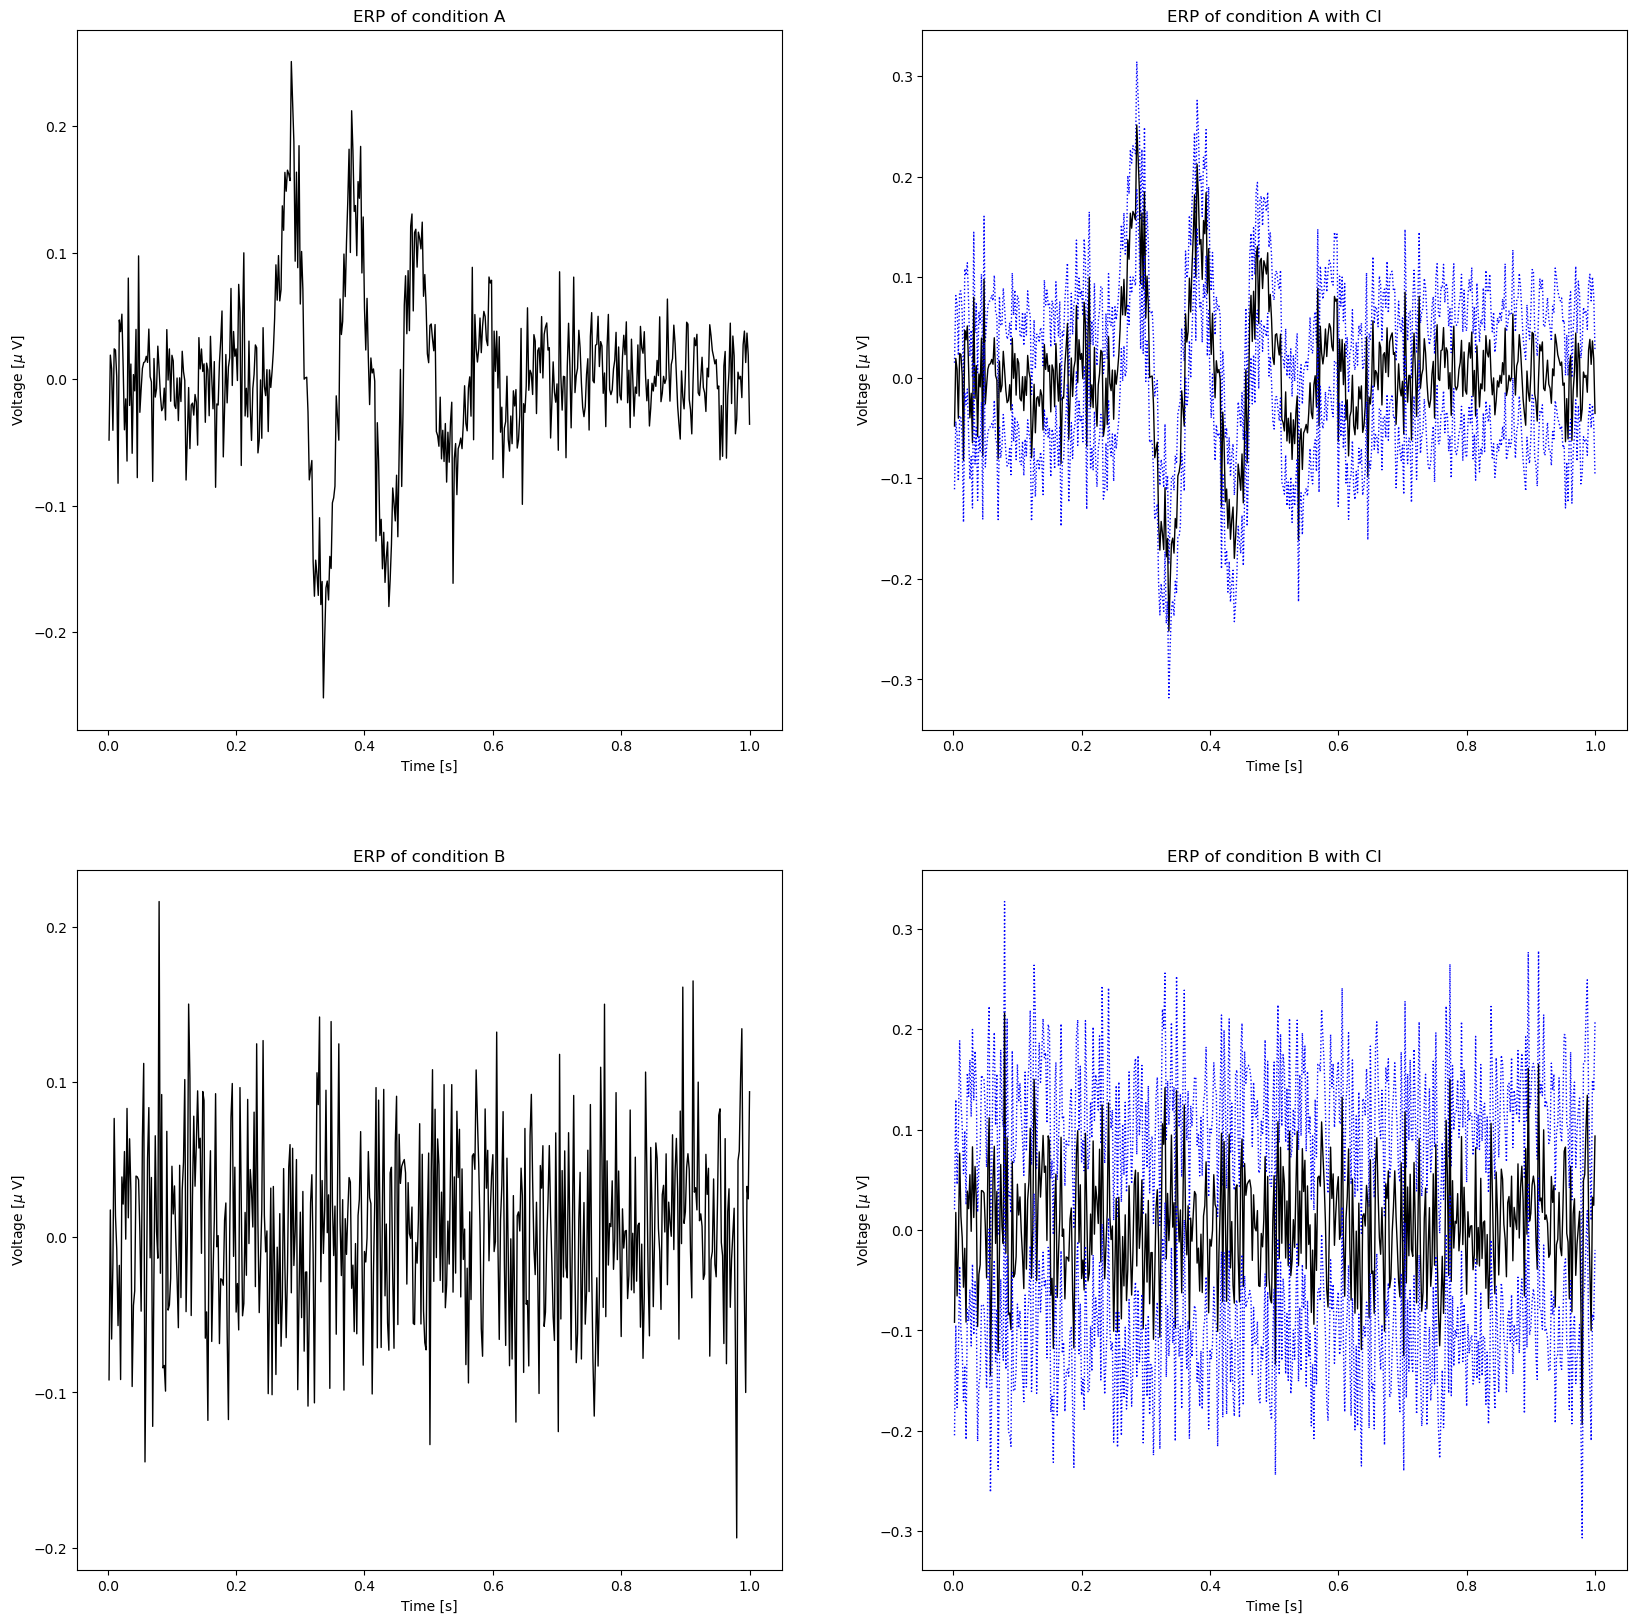

In [66]:
data: dict = loadmat('02_EEG-1.mat')
EEGa = data['EEGa']                                   # numpy.ndarray
EEGb = data['EEGb']                                   # numpy.ndarray
t = data['t'][0]                                      # numpy.ndarray
ntrials_a = len(EEGa)
ntrials_b = len(EEGa)
average_a = EEGa.mean(0)                    # Mean values at each time instance over the 1000 trials
average_b = EEGb.mean(0)
variance_a = EEGa.std(0)                    # Compute the std of the signal across trials.
variance_b = EEGb.std(0)
stddev_a = variance_a / sqrt(ntrials_a)     # Compute the std of the mean.
stddev_b = variance_b / sqrt(ntrials_b)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig.subplots_adjust()

axes[0,0].set_title('ERP of condition A')
axes[0,0].set_xlabel('Time [s]')
axes[0,0].set_ylabel('Voltage [$\mu$ V]')
axes[0,1].set_title('ERP of condition A with CI')
axes[0,1].set_xlabel('Time [s]')
axes[0,1].set_ylabel('Voltage [$\mu$ V]')
axes[1,0].set_title('ERP of condition B')
axes[1,0].set_xlabel('Time [s]')
axes[1,0].set_ylabel('Voltage [$\mu$ V]')
axes[1,1].set_title('ERP of condition B with CI')
axes[1,1].set_xlabel('Time [s]')
axes[1,1].set_ylabel('Voltage [$\mu$ V]')

axes[0,0].plot(t, average_a, 'k-', lw=1)
axes[1,0].plot(t, average_b, 'k-', lw=1)

axes[0,1].plot(t, average_a + 2 * stddev_a, 'b:', lw=1)  # 95% upper confidence interval
axes[0,1].plot(t, average_a, 'k-', lw=1)                 # Plot the ERP of condition A,
axes[0,1].plot(t, average_a - 2 * stddev_a, 'b:', lw=1)  # 95% lower confidence interval, 2 std from mean

axes[1,1].plot(t, average_b + 2 * stddev_b, 'b:', lw=1)  # 95% upper confidence interval
axes[1,1].plot(t, average_b, 'k-', lw=1)                 # Plot the ERP of condition A,
axes[1,1].plot(t, average_b - 2 * stddev_b, 'b:', lw=1)  # 95% lower confidence interval, 2 std from mean

plt.show()    
#savefig('imgs/2-2a')

### Task 2.2.2 Find the brain activity frequency in the data of condition A
Discussion question: What does this question refer to?

## Task 2.3 Features of observed rhythms in EEG
### Task 2.3.1 and 2.3.2

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


'Mean: 2.731148640577885e-17, Variance: 0.7104345436320261, Stddev: 0.015885799331252507'

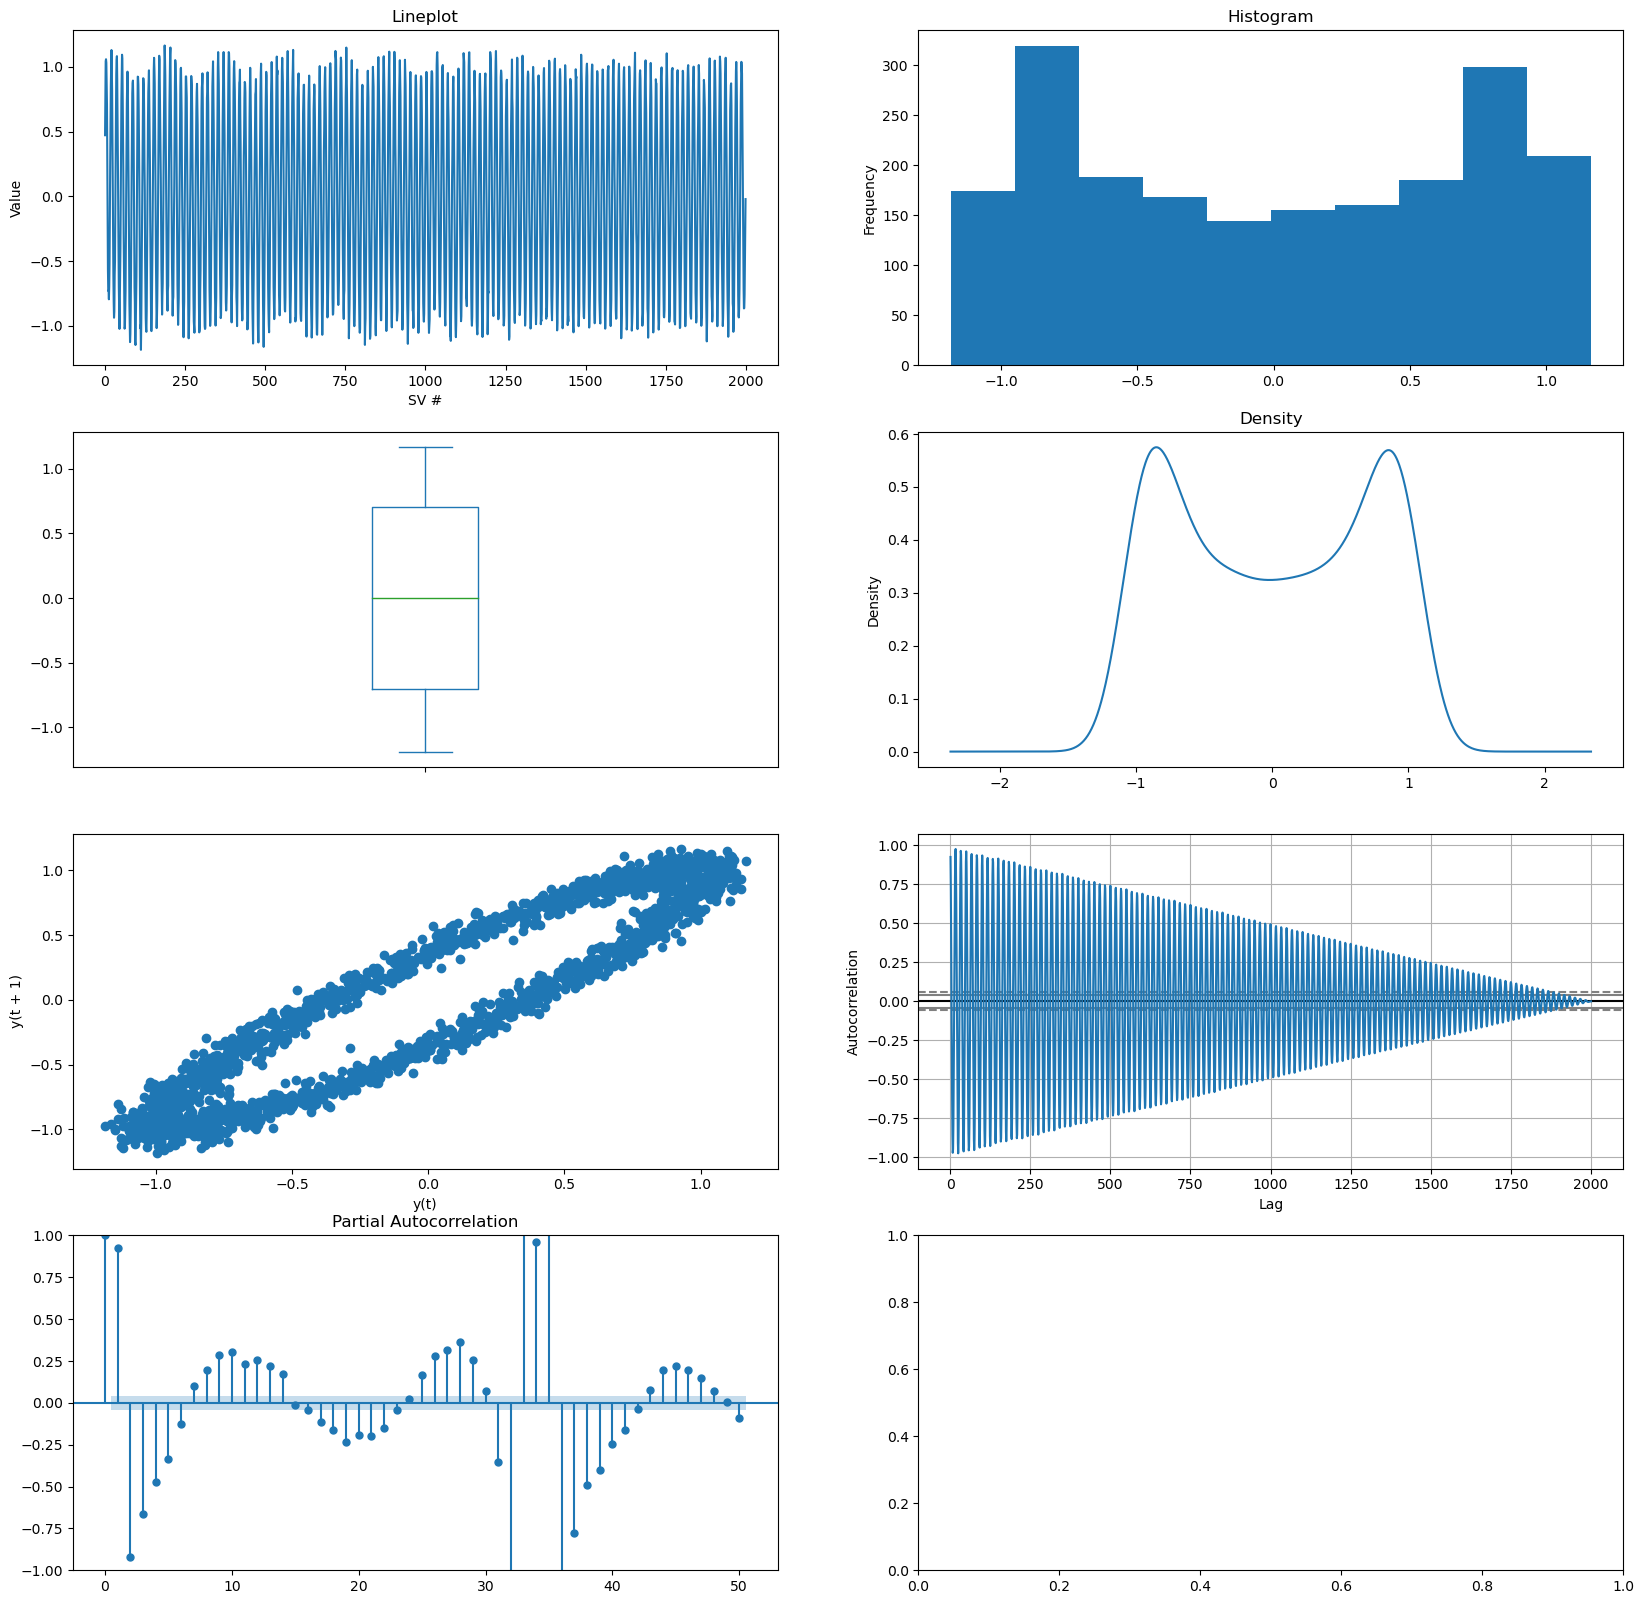

In [109]:
data: dict = loadmat('03_EEG-1.mat') # EEG = 2000 data points
EEG = np.transpose(data['EEG'])
np.shape(EEG)
plot_all(Series(EEG[0]), lags=50)

ntrials = len(EEG[0])
avg = EEG.mean()
variance = EEG.std()                 # Compute the std of the signal across trials.
stddev = variance / sqrt(ntrials)    # Compute the std of the mean.
f'Mean: {avg}, Variance: {variance}, Stddev: {variance / sqrt(ntrials)}'

## Task 2.3.3 Auto-covariance plot

### Why does the auto-covariance exhibit repeated peaks and troughs approximately every 0.0166 s?
Cause Gamma Band

The reason for the peaks at about 60Hz is because it hits the gamma band of cognitive activity in the brain.

### Task 2.3 Questions
- What features do you typically consider useful for analyzing and modeling time- series data?

- What features are specific for time-series, and what are general for both time-series and non-time-series data?

- How are auto-covariance and auto-correlation are defined for a time series? Give mathematical formulas for the definitions.

- Assume a short time-series {1, 2, 3, 4, 5, 6, 7, 8, 7, 6, 5, 4, 3, 2, 1}. First, calculate the auto-covariance and auto-correlations for all valid lags. Do the calculations manually. Then write a Python program to validate your calculations. Lastly, draw the ACF graph for the time series.